# Lesson 1 Notebook
In this notebook we will work with documents as vectors in a high dimensional space. We will look at some different ways of doing this using well established methods.

## Running this file on Google Colab
In this workshop we will be using Google Colab. To open this notebook in colab use the following URL: [Lesson 1 Notebook](https://colab.research.google.com/github/ENCCS/contemporary-nlp/blob/main/content/notebooks/lesson_1.ipynb)

You need to save a local copy of this notebook to your own Google Drive if you want the changes to be saved.

In [3]:
import zipfile
from pathlib import Path

## The data

In this notebook we will be working with comparing documents. We will work with real world data in the form of *patent applications*. These are documents which are submitted to patent organizations (in our case the European Patent Office, EPO) when requesting a patent. 

Published patent applications are open, so is a good source of example data for natural language processing.

The documents used in this workshop are downloaded from the EPO [European Publication Server web service](https://www.epo.org/searching-for-patents/data/web-services/publication-server.html). In particular, the patent applications are available as XML documents with clear structure. Below is an example of how these might look and the corresponding PDF version (which we will not be using).

![title](images/patent_application_pdf_xml.png)

We've prepared data for the workshop by extracting relevant fields from the XML documents and saved them as json-formatted documents. 

**N.b.** in a patent, each paragraph is numbered which can be used to cross reference between parts of the document. While this is essential to e.g. understand the claims, the methods we will use in this workshop can not make use of it, and therefore we haven't included them in the processed text.

### Downloading the data
We supply an archive of the data which we will now download

In [1]:
import urllib

In [6]:
data_url = "https://cdn.thingiverse.com/assets/d0/b3/68/63/1e/Gate_Guide_Spacer_v9.stl"
data_root = Path('data')
data_path = data_root / 'sampled_archive.zip'
data_root.mkdir(exist_ok=True)

In [11]:
urllib.request.urlretrieve(data_url, data_path)

(WindowsPath('data/sampled_archive.zip'),
 <http.client.HTTPMessage at 0x2623a2143c8>)

In [46]:
# This extracts the documents in the document root
with zipfile.ZipFile(data_path) as zf:
    zf.extractall(data_root)

Now let's have a look at how these files are structured. The archive contained two subdirectories, each having documents belonging to a specific class. Throughout this workshop we will be working with these two classes. When using NLP for semantic search, we are often tasked with searching some large set of documents for a specific subset. We will call the subset we're searching for the "relevant" set.

Our task is to achive as good *precision* and *recall* as possible on this relevant set.

In [29]:
import json
document_directories = [d for d in data_root.iterdir() if d.is_dir()]
document_classes = [d.name for d in document_directories]
print(document_classes)

['negative', 'positive']


The data is organized in text files containing JSON data, where each file is a single patent application. When parsed in python, the documents are organized as dictionaries.

Let's have a look at the keys they contain:

In [47]:
document_sample_path = next(document_directories[0].iterdir())
with open(document_sample_path) as fp:
    document_sample = json.load(fp)
print(document_sample.keys())

dict_keys(['abstract', 'claims', 'description', 'document_number', 'ipc_classes', 'language', 'publication_date'])


Here's a description of the different keys:
  - `abstract`: The text from the abstract of the document. This is often a succint text actually describing the contents of the patent.
  - `description`: This is the main body of text of the document, containing all materials which support the claims being made.
  - `claims`: This is a structured descriptions of the claims the patent seek. In other words, this is the description of what should be protected and is what the patent office should decide on.
  - `document_number`: This is the number assigned to an application when published.
  - `ipc_classes`: This is a list of IPC codes which has been assigned to the patent. The IPC system is a way of "tagging" the contributions of a patent so that it can be searched for in the future.
  - `language`: The language the application is publshied in. In this workshop we're only working with english patent applications.
  - `publication_date`: The date the application was published.

In this workshop, we'll mainly focus on the `abstract`, `claims` and `description`, since these are the parts containing natural language. Each of these keys in turn index a dictionary like below:

In [48]:
document_sample['abstract'].keys()

dict_keys(['en'])

Let's have a look at the contents. Claims and description can be long so we only look at the first 1000 characters.

In [49]:
document_sample['abstract']['en']

'Provided is a voltage discharging device. The voltage discharging device includes a battery, an inverter converting a DC power supplied from the battery into an AC power to output the converted AC power, a motor driven by the AC power outputted through the inverter, a main relay disposed between the battery and the inverter to switch the DC power supplied from the battery into the inverter, and a control unit detecting a key-off signal of the vehicle to discharge a DC link voltage of the inverter when the key-off signal is detected. The control unit discharges the DC link voltage by applying one of first and second forced discharging logics different from each other according to a driving state of the vehicle at a time point at which the key-off signal is detected.\n'

In [50]:
document_sample['claims']['en'][:1000]

'\nA voltage discharging device of a vehicle, the voltage discharging device comprising:\na battery(110);\nan inverter(130) for converting a DC power supplied from the battery(110) into an AC power to output the converted AC power;\na motor(140) driven by the AC power outputted through the inverter(130);\na main relay(120) disposed between the battery(110) and the inverter(130) to switch the DC power supplied from the battery(110) into the inverter(130); and\na control unit(150) for detecting a key-off signal of the vehicle and discharging a DC link voltage of the inverter when the key-off signal is detected,\nwherein the control unit(150) discharges the DC link voltage by applying one of first and second forced discharging logics different from each other according to a driving state of the vehicle at a time point at which the key-off signal is detected.\n\nThe voltage discharging device according to claim 1, wherein the control unit(150) determines a time point at which the main rela

In [51]:
document_sample['description']['en'][:1000]

'CROSS-REFERENCE TO RELATED APPLICATIONS\nThe present application claims priority under 35 U.S.C. 119 and 35 U.S.C. 365 to Korean Patent Application No. 10-2012-0109550 (filed on September 28, 2012), which is hereby incorporated by reference in its entirety.\nBACKGROUND\nEmbodiments relates to a vehicle, and more particularly, to a vehicle and a voltage discharging method thereof.\nAn inverter system that is a motor control unit used in eco-friendly vehicles is a main component belonging to an electric motor of a vehicle as an electric/electronic sub assembly (ESA) that converts a high-voltage DC power into an AC or DC power for controlling a motor.\nAs described above, a permanent magnet type motor may be applied to the eco-friendly vehicles. A motor that is applied as a driving unit in the eco-friendly vehicles is driven by phase current transmitted from an inverter for converting a DC voltage into a three-phase voltage by a pulse width modulation (PWM) signal of a control unit throu

In [ ]:
text_corpus = 

### Corpus

We'll be implementing a class to easily iterate over the documents 

In [73]:
from collections.abc import Sequence
from collections import defaultdict

class PatentCorpus:
    def __init__(self, *, document_root: Path, document_parts=('abstract', 'description', 'claims'), lang='en'):
        self.document_root = document_root
        self.document_parts = document_parts
        self.lang = lang

        self.documents  = sorted(self.document_root.glob('**/*.json'))
        self.labeled_documents = defaultdict(list)
        for document in self.documents:
            label = str(document.parent)
            self.labeled_documents[label].append(document)
    
    def __len__(self):
        return len(self.documents)

    def load_document(self, document_path):
        with open(document_path) as fp:
            document = json.load(fp)
            document_str = '\n'.join([document[part][self.lang] for part in self.document_parts])
            return document_str

    def __getitem__(self, item):
        # Lazily load documents here
        if isinstance(item, slice):
            document_paths = self.documents[item]
            document_str = [self.load_document(document_path) for document_path in document_paths]
        elif isinstance(item, Sequence):
            document_str = [self.load_document(self.documents[idx]) for idx in item]
        else:
            document_str = self.load_document(self.documents[item])
        return document_str

In [9]:
from collections.abc import Sequence
from collections import defaultdict
import json

class ZipPatentCorpus:
    def __init__(self, *, document_archive: Path, document_parts=('abstract', 'description', 'claims'), lang='en'):
        self.document_archive = document_archive
        self.document_zf = zipfile.ZipFile(self.document_archive)
        self.document_parts = document_parts
        self.lang = lang

        self.documents  = sorted(filename for filename in self.document_zf.namelist())
        self.labeled_documents = defaultdict(list)
        for document in self.documents:
            label, sep, file = document.rpartition('/')
            self.labeled_documents[label].append(document)
    
    def __len__(self):
        return len(self.documents)

    def load_document(self, document_path):
        with self.document_zf.open(document_path) as fp:
            document = json.load(fp)
            document_str = '\n'.join([document[part][self.lang] for part in self.document_parts])
            return document_str

    def __getitem__(self, item):
        # Lazily load documents here
        if isinstance(item, slice):
            document_paths = self.documents[item]
            document_str = [self.load_document(document_path) for document_path in document_paths]
        elif isinstance(item, Sequence):
            document_str = [self.load_document(self.documents[idx]) for idx in item]
        else:
            document_str = self.load_document(self.documents[item])
        return document_str

In [20]:
text_corpus = ZipPatentCorpus(document_archive=data_path)

In [19]:
text_corpus = PatentCorpus(document_root=data_root)

NameError: name 'PatentCorpus' is not defined

In [98]:
text_corpus[3:6]

['The present invention provides genetically modified eukaryotic host cells that produce isoprenoid precursors or isoprenoid compounds. A subject genetically modified host cell comprises increased activity levels of one or more of mevalonate pathway enzymes, increased levels of prenyltransferase activity, and decreased levels of squalene synthase activity. Methods are provided for the production of an isoprenoid compound or an isoprenoid precursor in a subject genetically modified eukaryotic host cell. The methods generally involve culturing a subject genetically modified host cell under conditions that promote production of high levels of an isoprenoid or isoprenoid precursor compound.\n',
 'Object To provide a peripheral structure of a battery for saddle-ride type vehicle which enhances maintenance capabilities while taking into account a case where other wires are connected to the battery.\nSolving Means In a saddle-ride type vehicle including: a battery (30) for supplying power to 

## Bag-of-Words

We'll start by using one of the simplest representations of these documents: the bag-of-words representation. In these, each document  is represented by a vector $\mathbf{d}_i$ of term presence variables $t_{i,j}$:

$$ \mathbf{d}_i = \begin{bmatrix}t_{i,1}& \dots & t_{i,n}\end{bmatrix} $$

The $t_{i,j}$ is the variable which expresses to what degree the term $j$ is present in the document. This variable can be a binary, where the prescence of the word is indicated or it can be a frequency of how often the word occurs in the document. In the latter case, the sum of all these frequencys are typically normalized so that they add up to $1$.

### Tokenization
To be able to construct this bag-of-words reprsentation, we need to decide on what terms are actually valid. We need to take this string of characters and divide it into *tokens*, a process referred to as *tokenization*. 

Tokenization is a difficult topic, because we need to make hard decisions which might destroy information. In english, it has been common to base tokenization on white space, since words in english are typically separated in this manner. Furthermore, some characters like `,` and `(` are mostly syntactic and the methods we'll look at today will not make use of this. We will therefore strip away a lot of these kinds of characters. We will also convert any upper case letter to lower case.

We start with looking at a simple way of doing this, and later progress to use prebuilt preprocessing steps with better fidelity.




In [145]:
import re

# We define the characters we would like to have in a word. 
# The pattern below says that a word is any sequence of characters 
# in the set of A-Z, a-z, 0-9 and the special characters "-", "+", "=" "'" and ".". 
# How to tokenize depends on the domain. For novels we wouldn't include the special characters, 
# but in this patent data it's often used in technical terms, e.g. in names for chemicals which we 
# would like to include as distinct terms like "2.2'-dihydroxy-4-methoxybenzophenone"
# The inclusion of the period "." means whe have to treat this separately when it's 
# surrounded by word-characters compared to when it's used to end a sentence.
# While this could be done using a regex, it would complicate the pattern. Instead we 
# take care of that using the pyhton `str.strip()` method
# Terms consisting only of numbers are often not useful for us, and could indeed introduce 
# spurious similarities. Two documents contraining the number "0.005" is probably not a good 
# indication that they are semantically similar. The way we handle this in the below pattern 
# is that we require our words to contain at least one letter

# Catches multiple (or none) of any of the characters we allow
general_pattern = r"[A-Za-z0-9\-\+='.]*" 
# Only matches letter
letters = r"[A-Za-z]"  
# Matches a string which is a sequence of our general pattern, but contains at least one letter
word_pattern = re.compile(f"{general_pattern}{letters}{general_pattern}")

def tokenize_text(text):
    # Lowercase each document and match to our regular expression, strip any trailing periods
    tokens = [word.strip('.') for word in re.findall(word_pattern, text.lower())]
    return tokens

In [143]:
example_text = """UV filters are suitably used in the compositions of the present invention. 
Suitable UV-absorbing substances is are: 4-Aminobenzoic acid and the esters and salts thereof, 
2-phenyl benzimidazole-5-sulfonic acid and the alkali and amine salts thereof, 4-dimethyl aminobenzoic 
acid and the esters and salts thereof, cinnamic acid and the esters and salts thereof, 4-methoxycinnamic 
acid and the esters and salts thereof, salicylic acid and the esters and salts thereof, 
2.4-dihydroxybenzophenone, 2.2'.4.4'-tetrahydroxybenzophenone, 2-hydroxy-4-methoxybenzophenone 
and its 5-sulfonic acid or the sodium salt thereof, 2.2'-dihydroxy-4.4'-dimethoxybenzophenone, 
2-hydroxy-5-chlorobenzophenone, 2.2'-dihydroxy-4-methoxybenzophenone, 
2.2'-dihydroxy-4.4'-dimethoxy-5.5'-disulfobenzo-phenone or the sodium salt thereof, 
2-hydroxy-4-octyloxybenzophenone, 2-hydroxy-4-methoxy-4'-methylbenzophenone, 3-benzyl-idenecampher, 
3-(4'-sulfo)-benzyl-idenebornane-2-one and the salts thereof, 3-(4'-methyl benzylidene)-DL-campher, 
and/or polysilicone-15. The amount of the UV-absorber ranges typically from about 0.01 % to 2.5%, 
more preferably from 0.05 % to 1 % by weight, calculated to the total composition."""

print(tokenize_text(example_text))

['uv', 'filters', 'are', 'suitably', 'used', 'in', 'the', 'compositions', 'of', 'the', 'present', 'invention', 'suitable', 'uv-absorbing', 'substances', 'is', 'are', '4-aminobenzoic', 'acid', 'and', 'the', 'esters', 'and', 'salts', 'thereof', '2-phenyl', 'benzimidazole-5-sulfonic', 'acid', 'and', 'the', 'alkali', 'and', 'amine', 'salts', 'thereof', '4-dimethyl', 'aminobenzoic', 'acid', 'and', 'the', 'esters', 'and', 'salts', 'thereof', 'cinnamic', 'acid', 'and', 'the', 'esters', 'and', 'salts', 'thereof', '4-methoxycinnamic', 'acid', 'and', 'the', 'esters', 'and', 'salts', 'thereof', 'salicylic', 'acid', 'and', 'the', 'esters', 'and', 'salts', 'thereof', '2.4-dihydroxybenzophenone', "2.2'.4.4'-tetrahydroxybenzophenone", '2-hydroxy-4-methoxybenzophenone', 'and', 'its', '5-sulfonic', 'acid', 'or', 'the', 'sodium', 'salt', 'thereof', "2.2'-dihydroxy-4.4'-dimethoxybenzophenone", '2-hydroxy-5-chlorobenzophenone', "2.2'-dihydroxy-4-methoxybenzophenone", "2.2'-dihydroxy-4.4'-dimethoxy-5.5'-di

In [146]:
from collections import Counter

tokenized_documents = [tokenize_text(document) for document in text_corpus]

# Count word frequencies

documents_term_frequencies = [Counter(term for term in document) for document in tokenized_documents]
total_term_frequency = Counter()
for document_term_frequency in documents_term_frequencies:
    total_term_frequency.update(document_term_frequency)

### The probability distribution of words

A fundamental challange with dealing with words, is that some are much more common than others. We would like the terms we use in our simple bag-of-words model to contain as much semantics about the document as possible, i.e. what *the document is actually about*. Many words play a more syntactic role, they glue the more semantically meaningful. Examples of these are `a`, `the`, `and`, `to`. In reality, they do convey semantics, e.g. `the white house` and `white house` have different meaning, but to handle this the model would have to be able to learn things about combination of terms, which our bag-of-words model cannot.

Let's have a look at the terms we have picked out and how common they are. We will concentrate on the most frequent terms.

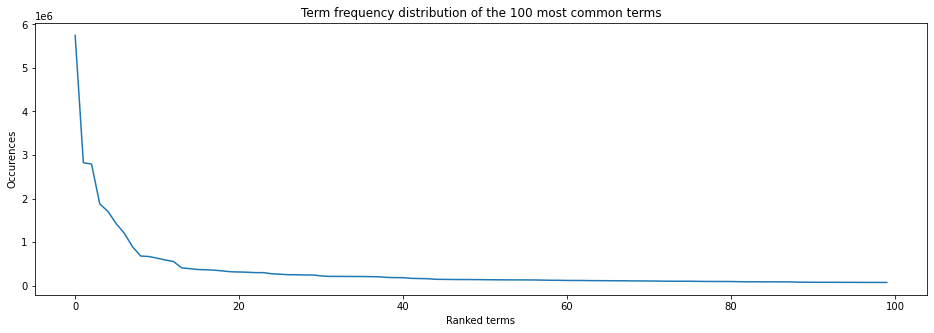

In [147]:
import matplotlib.pyplot as plt
import numpy as np

k = 100
words, counts = zip(*total_term_frequency.most_common(k))

plt.figure(figsize=(16,5))
plt.plot(np.arange(len(counts)), counts)
plt.xlabel("Ranked terms")
plt.ylabel("Occurences")
plt.title(f"Term frequency distribution of the {k} most common terms"); # The semi-colon just defers printing the last output here

### Zipf's law

As you can see in the above example, our term frequency distribution is heavily skewed towards the most common terms, while we have a tail of infrequent words which diminishes slowly. One way to think about this is that certain words are extremely common, while most words are used very rarely. In particular, words with very distinct semantics are rare in our corpus. This property of language was observered early on in linguistics, but the american George Kingley Zipf was the one who popularized it, which is the reason for why it's often referred to as Zipf's law.

*Why is this a problem?*

The reason is that we  will use methods which compare documents based on these frequencies, and the terms which dominates can drown out similarities between more semantically meaningful words.

As an example, let's have a look at the 50 most common words

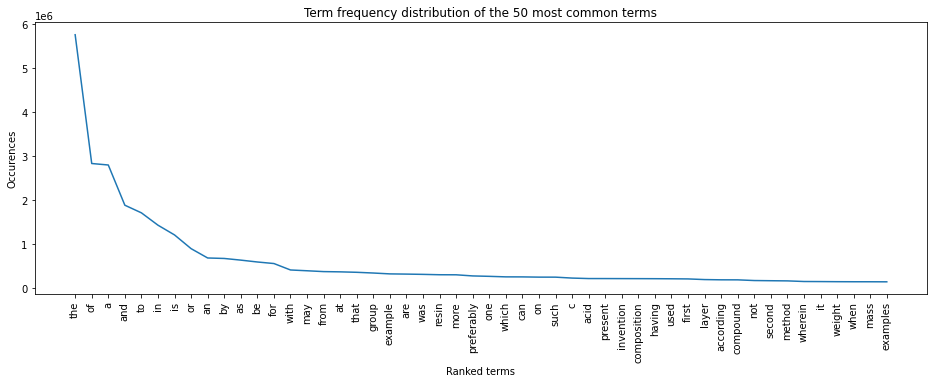

In [94]:
k = 50
words, counts = zip(*total_term_frequency.most_common(k))
x = np.arange(len(counts))
plt.figure(figsize=(16,5))
plt.plot(x, counts)
plt.xlabel("Ranked terms")
plt.ylabel("Occurences")
plt.title(f"Term frequency distribution of the {k} most common terms")
plt.xticks(x, words, rotation=90); # The semi-colon just defers printing the last output here

As you can see, even quite common words like `it` is far less common than words like `the`, `a` and `of`.

Let's zoom in and look at how this distribution look a bit further away from the top ranks

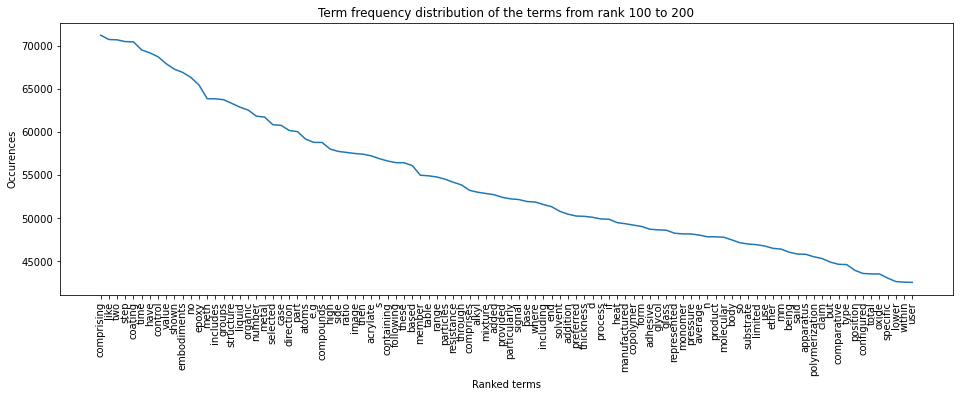

In [95]:
start_rank = 100
end_rank = 200
words, counts = zip(*list(total_term_frequency.most_common(end_rank))[start_rank:])
x = np.arange(len(counts))
plt.figure(figsize=(16,5))
plt.plot(x, counts)
plt.xlabel("Ranked terms")
plt.ylabel("Occurences")
plt.title(f"Term frequency distribution of the terms from rank {start_rank} to {end_rank}")
plt.xticks(x, words, rotation=90); # The semi-colon just defers printing the last output here

You can see that we start seing more words which would be useful to actually tell the contents of documents apart, such as `copolymer` or `pressure`.

Based on these statistics, we can make a **decision** about removing some words which we think will hurt our similiarity measure. We often refer to these words as *stop words*, beacuse they are words in a *stop list* which will be stopped from occuring in our documents.

In our case, we will just remove the words which are very dominant in the corpus

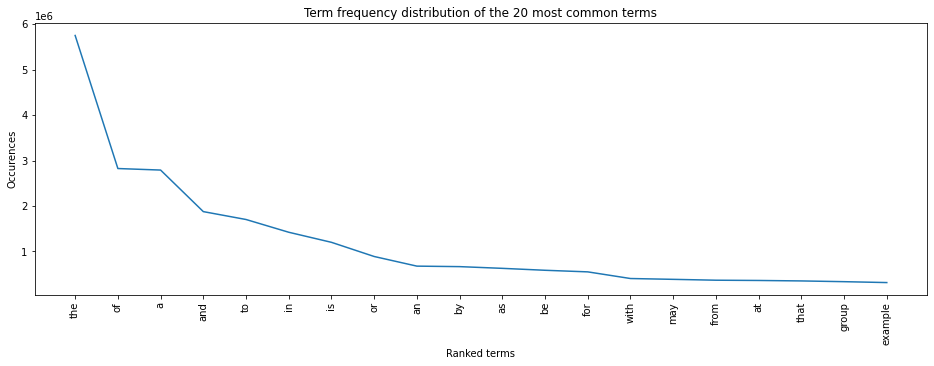

In [96]:
k = 20
words, counts = zip(*total_term_frequency.most_common(k))
x = np.arange(len(counts))
plt.figure(figsize=(16,5))
plt.plot(x, counts)
plt.xlabel("Ranked terms")
plt.ylabel("Occurences")
plt.title(f"Term frequency distribution of the {k} most common terms")
plt.xticks(x, words, rotation=90); # The semi-colon just defers printing the last output here

In [156]:
stoplist = set(['the', 'of', 'a', 'and', 'to', 'in', 'is', 'or', 'an', 'by', 'as', 'be', 'for'])

### Infrequent words

Apart from very common words hurting performance, there are many words which occur in only a single document. Common sources for this is misspellings or very niche words. While these words might be truly meaningful, if they occur in only one document we can't use them to find other documents which are similiar.

We therefore remove these infrequent words as well. While it's a given to drop those which only occur once, we might also wish to drop other infrequent words since they will not give us much in terms of statistical power.

In [118]:
def get_infrequent_terms(documents_term_frequencies, total_term_frequency, threshold):
    document_occurance_counts = Counter()
    for document_term_frequency in documents_term_frequencies:
        document_occurance_counts.update(document_term_frequency.keys()) # And a count once for each unique term in a document
    infrequent_by_document = set(term for term, count in document_occurance_counts.items() if count < threshold)
    infrequent_list_by_term = set(term for term, count in total_term_frequency.items() if count < threshold)
    return infrequent_by_document, infrequent_list_by_term

In [119]:
infrequent_by_document, infrequent_list_by_term = get_infrequent_terms(documents_term_frequencies, total_term_frequency, 2)

In [120]:
len(infrequent_list_by_term)

193031

In [121]:
len(total_term_frequency)

440736

In [124]:
frequency_by_document_by_threshold = []
frequency_by_term_by_threshold = []
for i in range(2, 5):
    infrequent_by_document, infrequent_by_term = get_infrequent_terms(documents_term_frequencies, total_term_frequency, i)
    frequency_by_document_by_threshold.append((i, len(infrequent_by_document)))
    frequency_by_term_by_threshold.append((i, len(infrequent_by_term)))

In [125]:
frequency_by_document_by_threshold

[(2, 278275), (3, 332612), (4, 357668)]

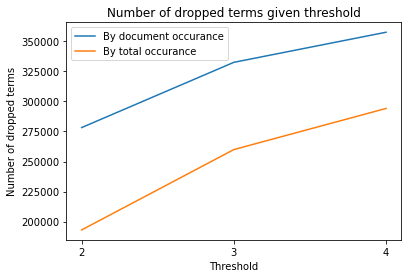

In [129]:
x1, y1 = zip(*frequency_by_document_by_threshold)
x2, y2 = zip(*frequency_by_term_by_threshold)

plt.plot(x1, y1, label="By document occurance")
plt.plot(x2, y2, label="By total occurance")
plt.xlabel("Threshold")
plt.ylabel("Number of dropped terms")
plt.title("Number of dropped terms given threshold")
plt.xticks(x1)
plt.legend();

In [97]:
drop_list = stoplist | set(term for term, count in total_term_frequency.items() if count < 2)
drop_list
# Only keep words that appear more than once
#processed_corpus = [[token for token in text if frequency[token] > 1] for text in texts]

{'fejes-toth',
 'argon-degassed',
 '5-ph-ph-o1',
 'tsubframe',
 'petrographic',
 '-fret',
 '-metal',
 '5-di-tert-butyl-4-hydroxyphenylpropyonyl',
 'grous',
 'aar88762',
 'ti0.09',
 '6-diisocyanatehexane',
 '8-octanemethylene',
 'resinbefore',
 'n-dodecoxy',
 'coo-m+',
 'crank-shape',
 '3-divinyl1',
 'val27ala',
 'product.specific',
 'x-simeny3-n',
 'lrrc15',
 '10...control',
 'monoalkane',
 'a218',
 'less.percentage',
 'lymphocyte-',
 'geothermal-well',
 'microphage',
 'plsc-11',
 'polyurethaneureas',
 'catapano',
 'tetrafluoroethylene-perfluorodioxol',
 'jp-2004-302451-a',
 'l-7622',
 'r34each',
 'sheet-shapedproduct',
 '6-hexamethylene-0',
 'xt+1=xt+',
 'tai-2047',
 'butyl-dimethyl',
 '2-f-6-nbdlg',
 'prss53',
 'polymer-ize',
 '3-dipolar',
 'e-sitnr13-n',
 'ssydkfqtv',
 'pande',
 'nee26',
 'za-30',
 'cmc-12',
 '4-chloro-m-phenylene',
 'n-dihydrocarbylhydroxylamine',
 'peak-holding',
 'fefef',
 'm1=0',
 'mckee',
 'co-occur',
 'arylcarbonylalkyl',
 'size=17.7',
 'resm',
 'val176phe',
 

### *Choosing* a vocabulary

What terms we choose to include in our vocabulary will affect the performance of our methods. We would like to include as many meaningful terms as possible, but there is a trade-off to make here. The larger we make our vocabulary, the more computationally costly will our methods be. Furthermore, a large vocabulary will essentially lead to a underdetermined system, so we might run into issues of identifiability (essentially that there are an infinite number of equally good solutions).

This leads us to having to limit our vocabulary. We often do this in a data driven fashion, using word frequencies as we've discussed above or deciding on keeping the top $k$ words (excluding those on the stop list). Here we'll do the latter and you will be tasked with experimenting with different choices for the number of words.

**Q: How to you know what size your vocabulary should have?**

**A: You run experiments**



In [161]:
desired_vocab_size = 100000
filtered_counts = Counter(total_term_frequency)
for stopword in stoplist:
    del filtered_counts[stopword]
vocabulary = set(term for term, count in filtered_counts.most_common(desired_vocab_size))

In [162]:
vocabulary

{'electrolytically',
 'sec-octyl',
 'aralkoxy',
 'energy-emission',
 'beta-dicarbonyl',
 'stinging',
 'palpable',
 'hemostasis',
 'rubber-philic',
 'h-50',
 'bfp',
 'la81',
 'tetraethylhexanoate',
 'lozenges',
 'accomplishing',
 'ka-1163',
 '3-triazol-4-yl',
 'command',
 'silanated',
 'crucible',
 'fu',
 'heb',
 '21a',
 'cabs',
 'cyclobutane-1',
 '1h-pyrazolo',
 'banking',
 'butylethylpropanediol',
 'protections',
 '-co-nh-nh2',
 'adequately',
 'folr1',
 'fn1500',
 'suits',
 'dithiothreitol',
 '6-dihydroxynaphthalene',
 'pbat',
 'chiralpak',
 'd-9',
 'wireless',
 'to-0125528',
 '2pz-cn',
 'pair-containing',
 'di-t-butylphenol',
 'fulcrum',
 '3-dihexadecyloxypropyl-oxymethyloxy',
 'enriches',
 'migratory',
 'normalizes',
 '-conhr',
 'crowding',
 'i200',
 '1b-2',
 'anti-counterfeit',
 'tevaluatehrpd',
 'recommends',
 'fist',
 'ethylene-methacrylate',
 'newest',
 'synchronous',
 'tautomerism',
 'ctra',
 'self-weight',
 'amino-based',
 'complicating',
 'r1-',
 'n-trimethyladamantyl',
 'vul

In [ ]:
### Indexed words

### Indexed words
When working with terms, we want to abstract away the actual string the terms refer to, and instead use them to index into e.g. word vectors. We will do this by assigning each term in our vocabular an index. In the future when we refer to the terms in code, it is through this index.

We will need to keep this index around, because any future text we want to tokenize and index needs to use the same method if we are to use the same models. It's also good practice to try to make it deterministic, so e.g. assign the indices based on sorted order.

In [179]:
term_to_index = {term:i for i, term in enumerate(sorted(vocabulary))}
index_to_term = {i:term for term, i in term_to_index.items()}  # it's convenient to have the inverse mapping
print("Index of term `manufactured`:", term_to_index['manufactured'])

Index of term `manufactured`: 58958


### The preprocessed data

We're now ready to create our basic dataset, by first taking our tokenized documents and assigning each valid term an index. Any terms which are not in the `term_to_index` will be dropped from the text.

In [167]:
def encode_document(tokenized_document, term_to_index):
    return [term_to_index[term] for term in tokenized_document if term in term_to_index]

def decode_document(encoded_document, index_to_term):
    return [index_to_term[index] for index in encoded_document]

In [186]:
tokenized_example = tokenize_text(example_text)
print("Tokenized text before dropping words:\n", tokenized_example)
encoded_example = encode_document(tokenized_example, term_to_index)
print("\nEncoded text, dropping words not in the vocabulary:\n", encoded_example)
inv_encoded_example = decode_document(encoded_example, index_to_term)
print("\nDecoded again:\n", inv_encoded_example)

Tokenized text before dropping words:
 ['uv', 'filters', 'are', 'suitably', 'used', 'in', 'the', 'compositions', 'of', 'the', 'present', 'invention', 'suitable', 'uv-absorbing', 'substances', 'is', 'are', '4-aminobenzoic', 'acid', 'and', 'the', 'esters', 'and', 'salts', 'thereof', '2-phenyl', 'benzimidazole-5-sulfonic', 'acid', 'and', 'the', 'alkali', 'and', 'amine', 'salts', 'thereof', '4-dimethyl', 'aminobenzoic', 'acid', 'and', 'the', 'esters', 'and', 'salts', 'thereof', 'cinnamic', 'acid', 'and', 'the', 'esters', 'and', 'salts', 'thereof', '4-methoxycinnamic', 'acid', 'and', 'the', 'esters', 'and', 'salts', 'thereof', 'salicylic', 'acid', 'and', 'the', 'esters', 'and', 'salts', 'thereof', '2.4-dihydroxybenzophenone', "2.2'.4.4'-tetrahydroxybenzophenone", '2-hydroxy-4-methoxybenzophenone', 'and', 'its', '5-sulfonic', 'acid', 'or', 'the', 'sodium', 'salt', 'thereof', "2.2'-dihydroxy-4.4'-dimethoxybenzophenone", '2-hydroxy-5-chlorobenzophenone', "2.2'-dihydroxy-4-methoxybenzophenone",